In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
dataiter=iter(data_loader)
images,labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [7]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [28]:
model = Autoencoder()
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [29]:
num_epochs = 20
outputs=[]
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    #img = img.reshape(-1,28*28)
    recon = model(img)
    loss = criterion(recon, img)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  print(f'Epoch : {epoch+1}, Loss : {loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch : 1, Loss : 0.0114
Epoch : 2, Loss : 0.0065
Epoch : 3, Loss : 0.0045
Epoch : 4, Loss : 0.0039
Epoch : 5, Loss : 0.0037
Epoch : 6, Loss : 0.0033
Epoch : 7, Loss : 0.0031
Epoch : 8, Loss : 0.0028
Epoch : 9, Loss : 0.0031
Epoch : 10, Loss : 0.0033
Epoch : 11, Loss : 0.0026
Epoch : 12, Loss : 0.0029
Epoch : 13, Loss : 0.0025
Epoch : 14, Loss : 0.0028
Epoch : 15, Loss : 0.0028
Epoch : 16, Loss : 0.0027
Epoch : 17, Loss : 0.0029
Epoch : 18, Loss : 0.0026
Epoch : 19, Loss : 0.0028
Epoch : 20, Loss : 0.0023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


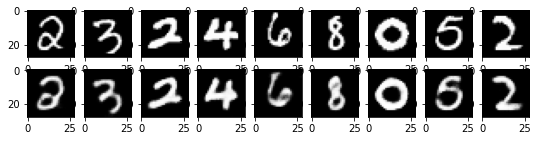

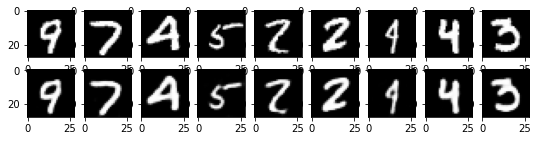

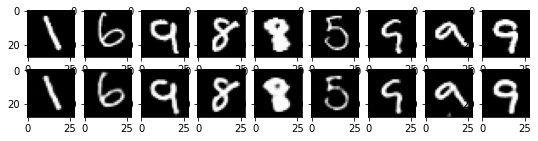

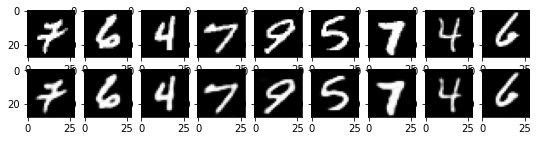

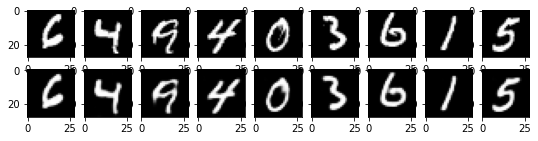

In [31]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize = (9, 2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if(i>=9):
      break
    plt.subplot(2,9,i+1)
    #item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

    for i, item in enumerate(recon):
      if i>=9:
        break
      plt.subplot(2,9,9+i+1)# row_length + i + 1
      #item = item.reshape(-1, 28, 28)
      plt.imshow(item[0])



